In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Hyperparameters

input_size=9 #same as features
output_size=1
hidden_size=64
num_layers=2
n_seq = 200
features = 9

In [3]:
#Load Data

dataset = np.load('sliced_3x3.npy')
dataset = dataset[0:1001]
print(dataset.max())
dataset = dataset/dataset.max()
print(dataset.shape)

139.66844
(1001, 3, 3)


In [4]:
#Reshape Data

X = dataset.reshape(1001,9)
X = X[:-1]
X = X.reshape(X.shape[0],X.shape[1],1)
print(X.shape)

Y = dataset[:,1,1]
Y = Y[1:]
Y = Y.reshape(Y.shape[0],1)
print(Y.shape)

(1000, 9, 1)
(1000, 1)


In [5]:
#Make Sliding Windows

total_length = X.shape[0]
sliding_windows = total_length-(n_seq-1)
print('total windows: ', sliding_windows)

temp = np.zeros((sliding_windows, n_seq,features))
temp2 = np.zeros((sliding_windows, n_seq,1))

for i in range(sliding_windows):
    temp[i,:]=X[i:i+n_seq,:,0]
    temp2[i,:]=Y[i:i+n_seq,:]

print(temp.shape)
print(temp2.shape)

xx = temp.reshape(sliding_windows, 1, n_seq, features )
yy = temp2.reshape(sliding_windows, 1, n_seq, 1 )
print(xx.shape, yy.shape)

total windows:  801
(801, 200, 9)
(801, 200, 1)
(801, 1, 200, 9) (801, 1, 200, 1)


In [6]:
# LSTM Code

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 
        
    def forward(self, x):
        x, _ = self.lstm(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # input format converted to a linear layer
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [7]:
# Instantiate Model
model = LSTM(input_size, hidden_size, output_size, num_layers)
print(model)

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

LSTM(
  (lstm): LSTM(9, 64, num_layers=2)
  (reg): Linear(in_features=64, out_features=1, bias=True)
)


In [11]:
def train(model, x, y, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    
    for step in range(n_steps):
        
        x_in = x[step]
        y_out = y[step]
        
        prediction = model(x_in)
        #calculate loss
        loss = criterion(prediction, y_out[0])
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if step%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(y_out[0].data.numpy().flatten(), 'r') # input
            plt.plot(prediction.data.numpy().flatten(), 'b') # predictions
            plt.show()
    
    return model

torch.Size([801, 1, 200, 9]) torch.Size([801, 1, 200, 1])


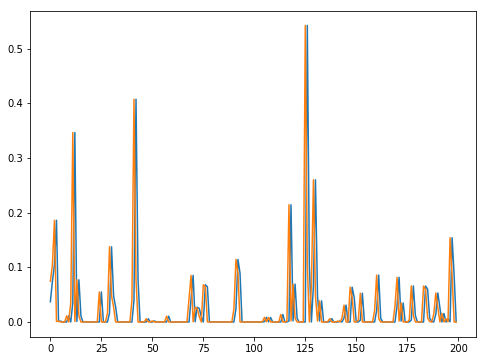

In [12]:
n_steps = 400
print_every = 50

x = torch.tensor(xx).float()
y = torch.tensor(yy).float()

print(x.shape, y.shape)

plt.figure(figsize=(8,6))
plt.plot(x[0,0,:,4].numpy())
plt.plot(y[0,0,:,0].numpy())
plt.show()

Loss:  0.0035707529168576


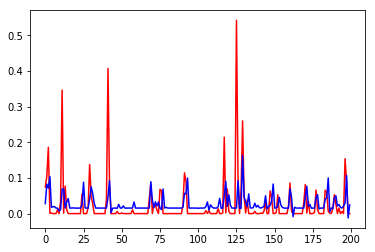

Loss:  0.0033599671442061663


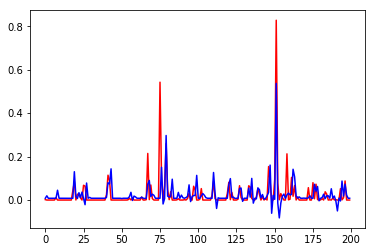

Loss:  0.004115594085305929


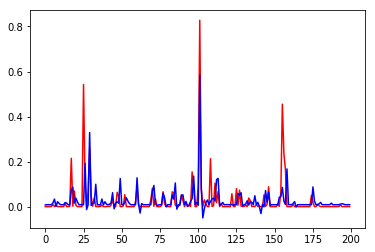

Loss:  0.002098497236147523


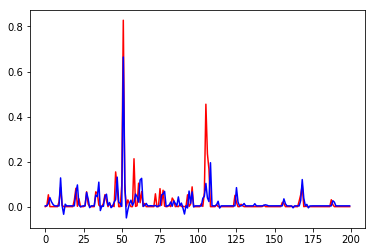

Loss:  0.0020787445828318596


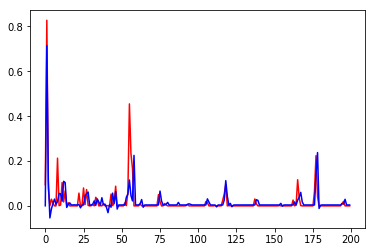

Loss:  0.0022771316580474377


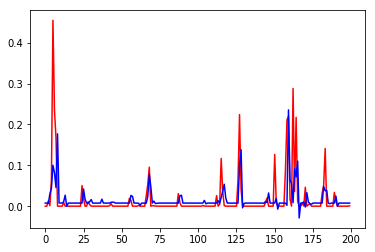

Loss:  0.0016217101365327835


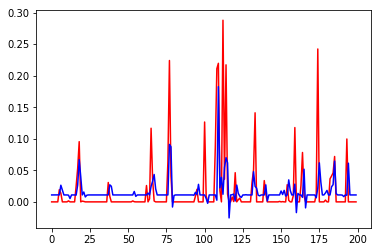

Loss:  0.0028215900529175997


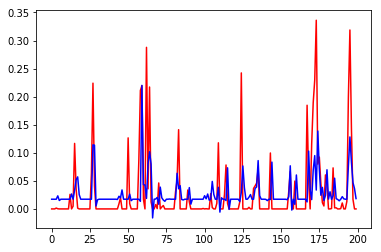

In [13]:
trained = train(model, x, y, n_steps, print_every)

torch.Size([201, 1, 200, 9]) torch.Size([201, 1, 200, 1])
Loss:  0.0033554807305336


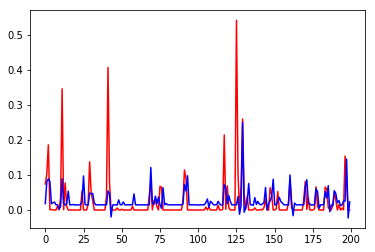

Loss:  0.004124283324927092


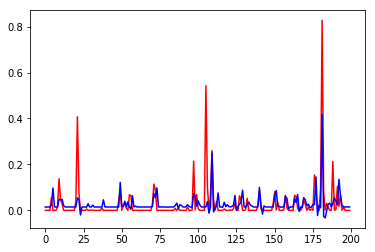

Loss:  0.004121487960219383


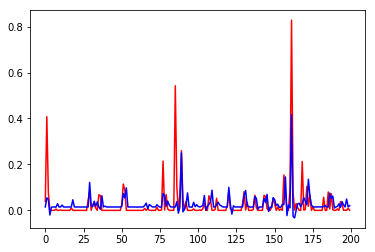

Loss:  0.004599624313414097


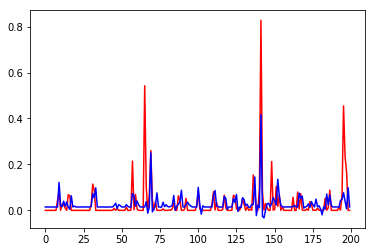

Loss:  0.00455818697810173


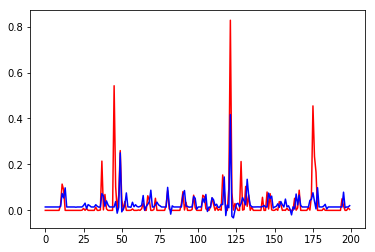

Loss:  0.004500938579440117


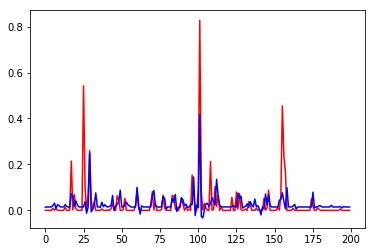

Loss:  0.004382464103400707


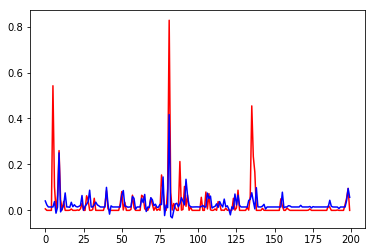

Loss:  0.002912868745625019


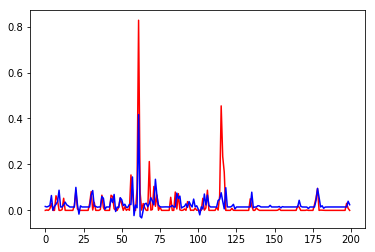

Loss:  0.002856367500498891


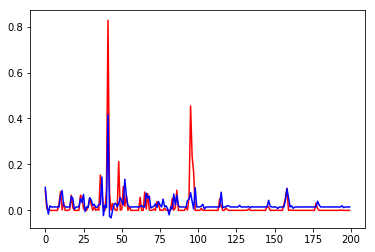

Loss:  0.002963119186460972


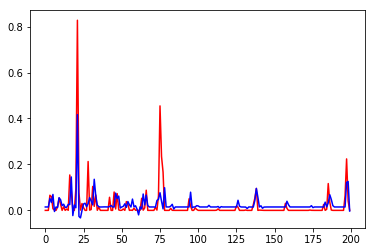

In [15]:
with torch.no_grad():
    x_test = x[600:]
    y_test = y[600:]
    
    print(x_test.shape, y_test.shape)
   
    hidden = None
    for step in range(200):
        x_in = x[step]
        y_out = y[step]
        
        prediction = model(x_in)
        # calculate the loss
        loss = criterion(prediction, y_out[0])
        
        # display loss and predictions
        if step%20 == 0:        
            print('Loss: ', loss.item())
            plt.plot(y_out[0].data.numpy().flatten(), 'r') # input
            plt.plot(prediction.data.numpy().flatten(), 'b') # predictions
            plt.show()
